## OCNT-DMSLIB-0-CRE DMS Assay Run #2: MC4R, Gs, Ipsen (DMS11) Model Extension

This report extends the full analysis of the DMS11 dataset to  force the reference genotype for each position to be "WT, No Ipsen" across all mutants, even those under an Ipsen condition. This permits a more appropriate comparison to the summary statistics gather from various papers. Using the summary statistics, we can make the same heatmaps as usual:

In [39]:
library(magrittr)
library(data.table)
library(ggpubr)
library(vroom)
library(scales)
library(colorspace)
library(scico)
library(ggridges)
library(ggalluvial)
library(knitr)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

In [3]:
sumstats <- dir_ls(path = "../sumstats/MC4R/DMS11/altmod/", regexp = "mc4r-cre-chap.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term)) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/mc4r/mc4r-wt-prot.tsv") %>%
    select(WT_AA_Short, Pos) %>%
    rename("pos" = "Pos", "wt_aa" = "WT_AA_Short")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:332

Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
sumstats_all <- bind_rows(
    compute_difference("aMSH1e-06", "Forsk2.5e-05", sumstats),
    compute_difference("None0", "Forsk2.5e-05", sumstats)
) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

In [36]:
norm_heatmap_l2fc <- sumstats_all %>%
    mutate(aa = gsub("X", "Stop", aa)) %>%
    filter(grepl("aMSH", condition), !grepl("WT", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = estimate)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~if_else(grepl("_Ipsen", aa), "aMSH1e-06 - Forsk2.5e-05 With Ipsen", "aMSH1e-06 - Forsk2.5e-05"), ncol = 1, scales = "free_y") +
            ggtitle("DMS11 // Log2FoldChange // WT No Ipsen Reference")

norm_heatmap_z <- sumstats_all %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    filter(grepl("aMSH", condition), !grepl("WT", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = statistic)) +
            scale_fill_scico_mid(palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~if_else(grepl("_Ipsen", aa), "aMSH1e-06 - Forsk2.5e-05 With Ipsen", "aMSH1e-06 - Forsk2.5e-05"), ncol = 1, scales = "free_y") +
            ggtitle("DMS11 // Z-Statistic // WT No Ipsen Reference")

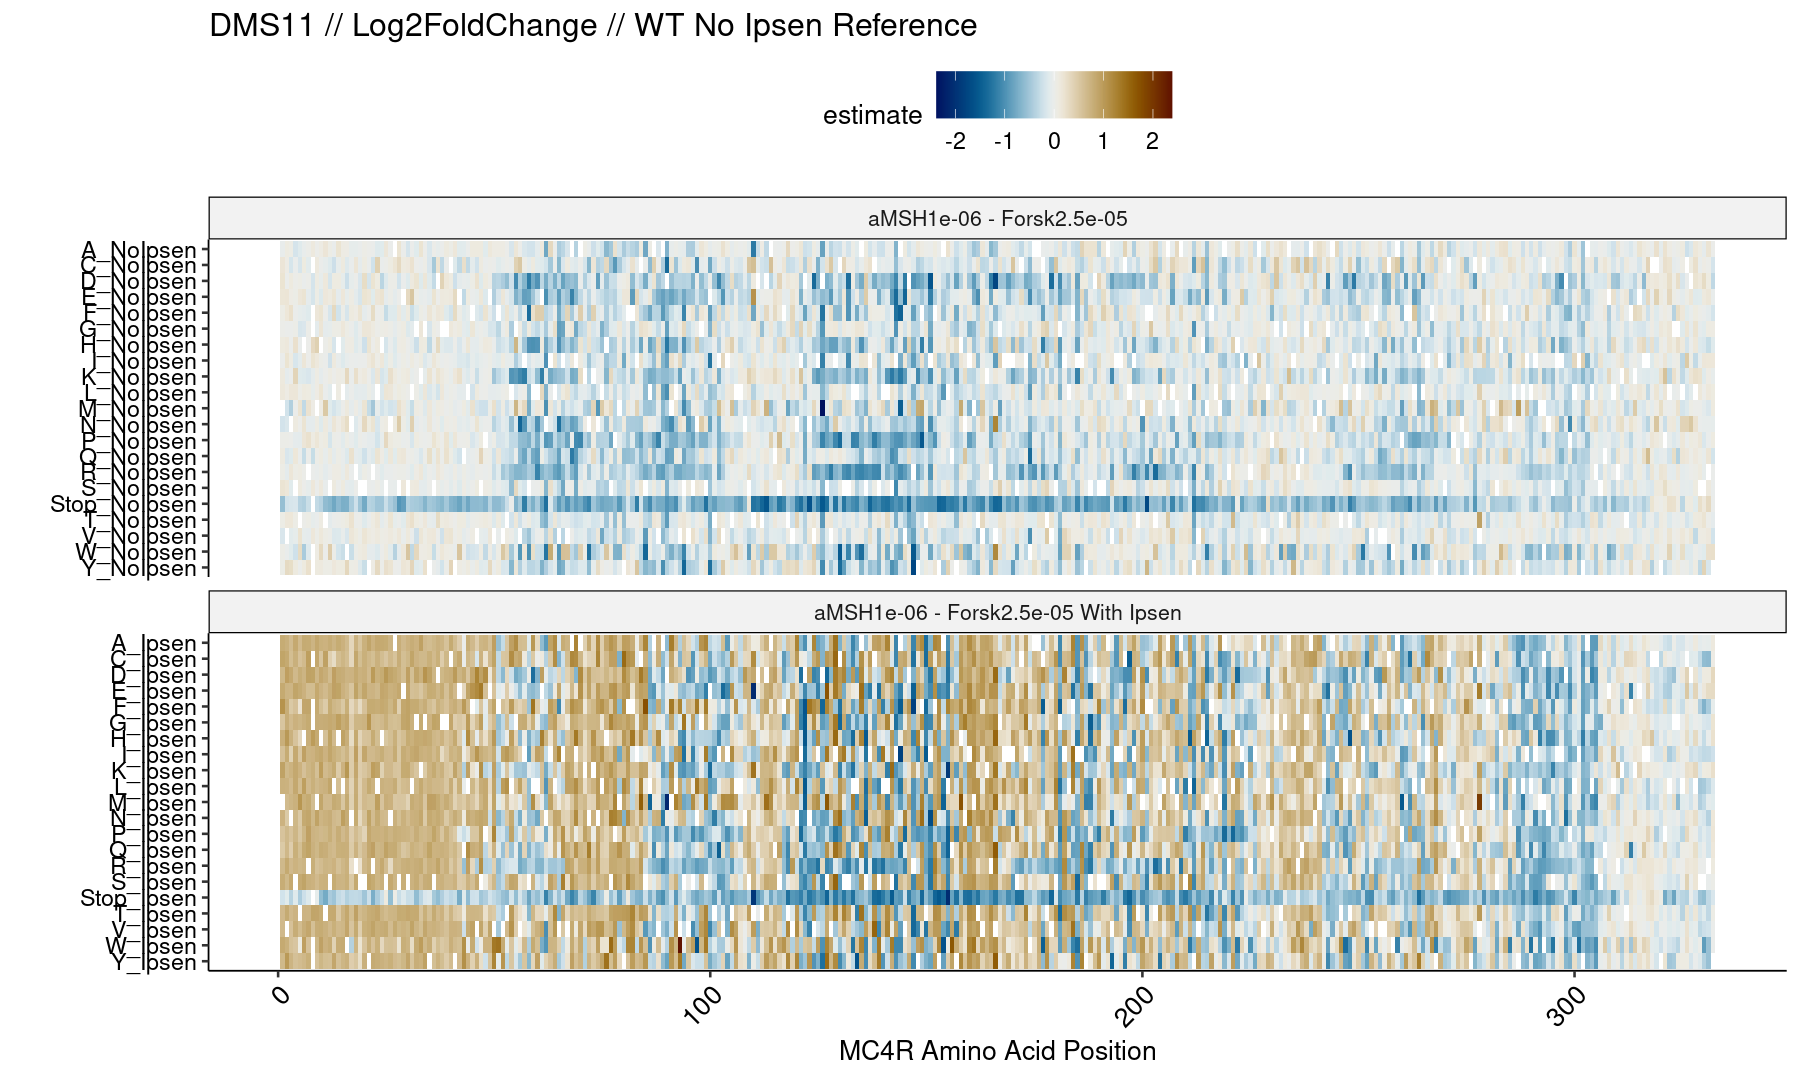

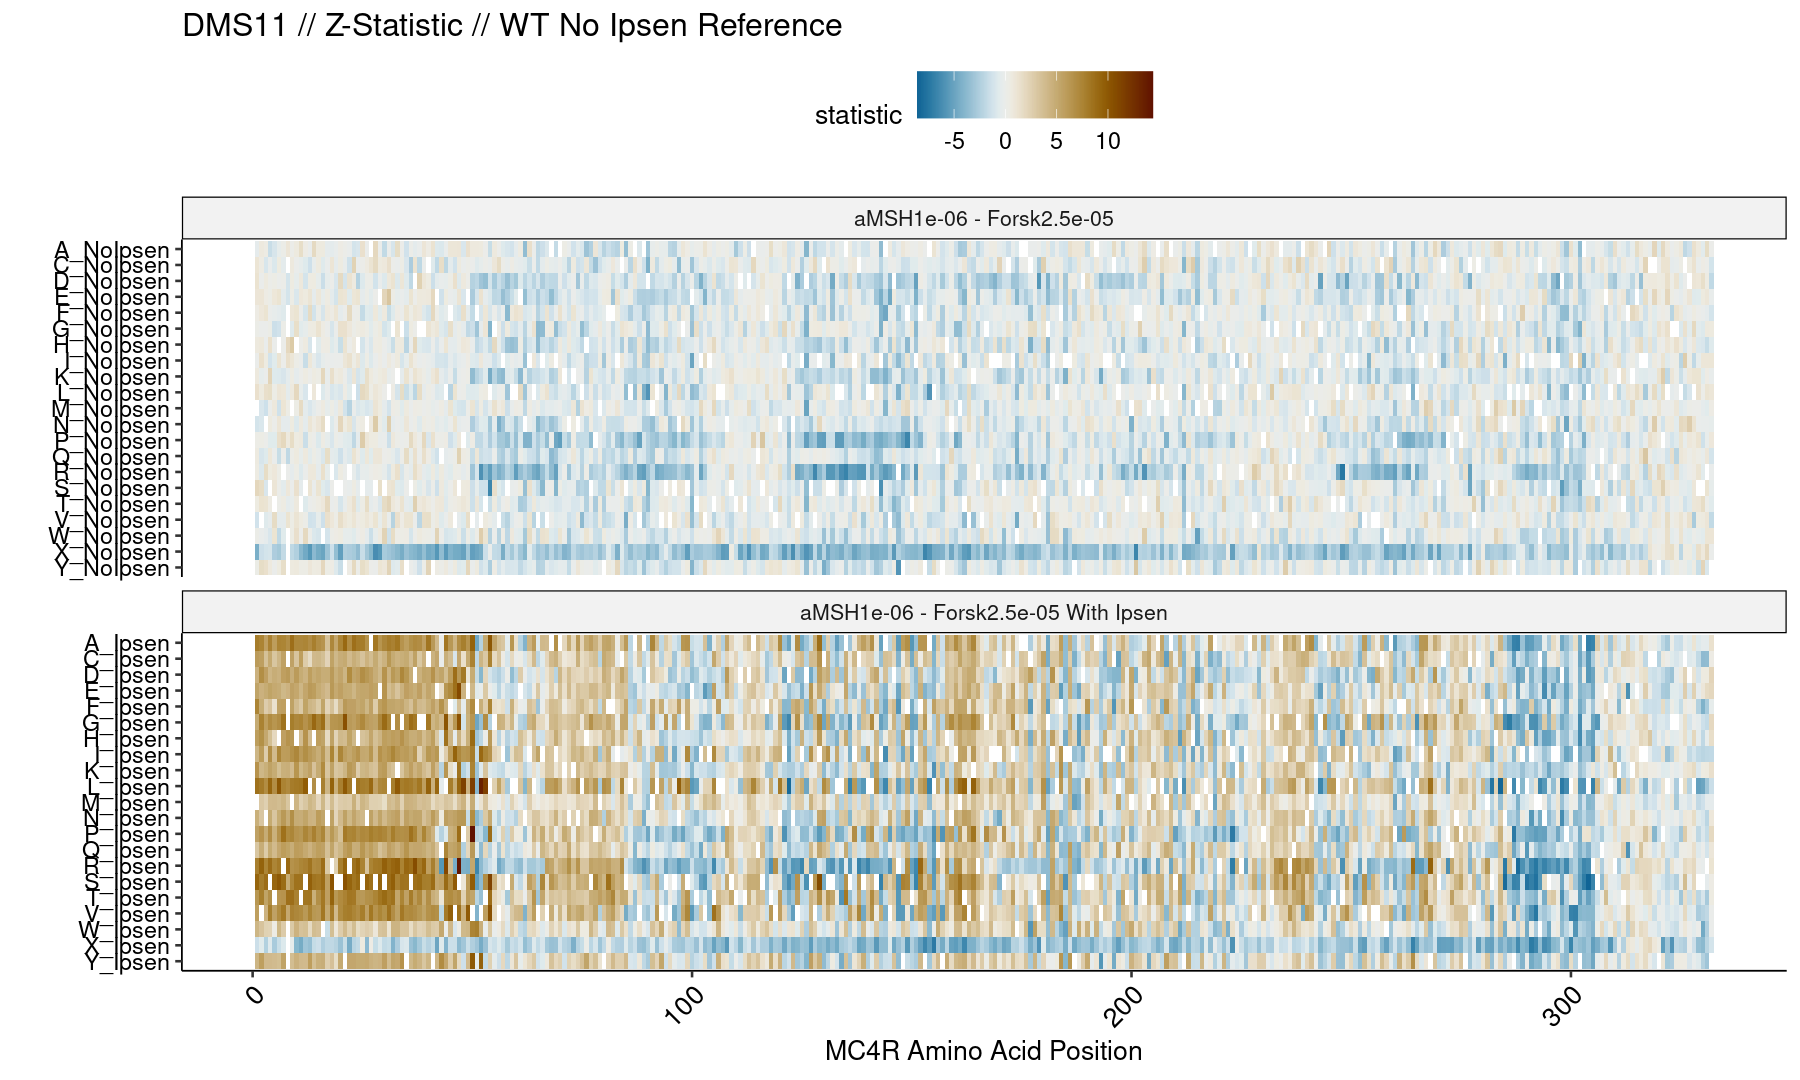

In [37]:
options(repr.plot.width = 15, repr.plot.height = 9)
norm_heatmap_l2fc
norm_heatmap_z
ggsave("../dataviz/MC4R/MC4R-Gs-Ipsen-AltMod-L2FC.pdf", norm_heatmap_l2fc, width = 15, height = 9)
ggsave("../dataviz/MC4R/MC4R-Gs-Ipsen-AltMod-Z.pdf", norm_heatmap_z, width = 15, height = 9)

Next, we compare these summary statistics to published variant sets from Wang et al (2014):

In [24]:
wang2014 <- read_tsv("../data/annotations/Wang-Ipsen2014.tsv")
huang2017 <- read_tsv("../data/annotations/Huang2017.tsv")

Rows: 12 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): mut

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 72 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): class, mut

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


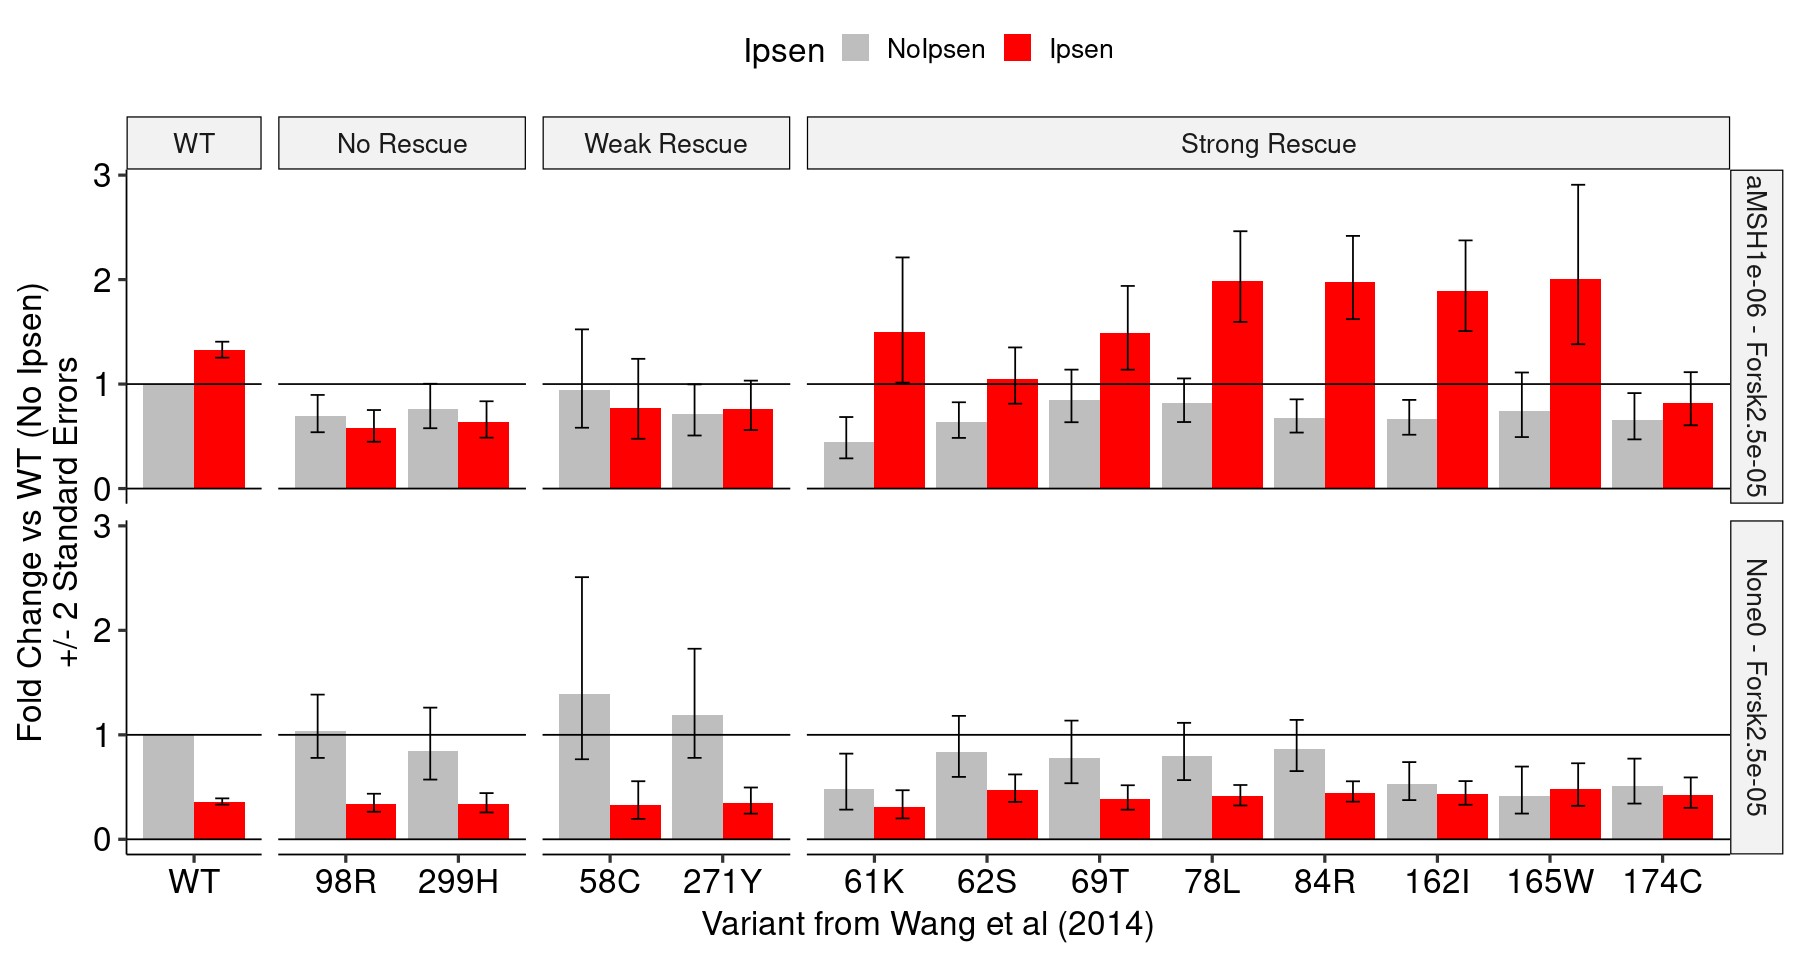

In [109]:
wt_ref <- tibble("mut_id" = "WT",
                 "estimate" = 0,
                 "pos" = -1,
                 "Ipsen" = "NoIpsen",
                 "class" = "WT",
                 "condition" = c("aMSH1e-06 - Forsk2.5e-05", "None0 - Forsk2.5e-05"))

wt_ipsen <- sumstats_all %>%
    filter(pos == -1) %>%
    group_by(condition) %>%
    summarize(estimate = mean(estimate),
              std.error = sqrt(sum(std.error^2))) %>%
    mutate(pos = -1,
           Ipsen = "Ipsen",
           mut_id = "WT",
           class = "WT")

barplot_data <- sumstats_all %>%
    mutate(mut_id = gsub("_.*", "", paste0(pos, aa))) %>% 
    filter(mut_id %in% wang2014$mut) %>% 
    separate(aa, c("aa", "Ipsen"), sep = "_") %>%
    mutate(aa = if_else(aa == "X", "Stop", aa),
           #aa = relevel(as.factor(aa), ref = "WT"),
           Ipsen = relevel(as.factor(Ipsen), ref = "NoIpsen"),
           class = case_when(mut_id %in% c("98R", "299H") ~ "No Rescue",
                             mut_id %in% c("58C", "271Y") ~ "Weak Rescue",
                             grepl("WT", mut_id) ~ "WT",
                             TRUE ~ "Strong Rescue")) %>%
    bind_rows(wt_ref) %>%
    bind_rows(wt_ipsen) %>%
    mutate(Ipsen = fct_rev(Ipsen),
        class = factor(class,
                       levels = c("WT", "No Rescue",
                                  "Weak Rescue", "Strong Rescue")))

options(repr.plot.width = 15, repr.plot.height = 8, warn = -1)
barplot_wang <- ggplot(barplot_data) +
        geom_bar(aes(x = reorder(mut_id, pos), y = 2^estimate,
                       #ymin = estimate - 2*std.error,
                       #ymax = estimate + 2*std.error,
                       fill = Ipsen), stat = "identity",
                       position = "dodge") +
        geom_errorbar(aes(x = reorder(mut_id, pos), y = 2^estimate,
                       ymin = 2^(estimate - 2*std.error),
                       ymax = 2^(estimate + 2*std.error),
                       fill = Ipsen),
                       position = position_dodge(width = 1), width = 0.25) +
        theme_pubr(base_size = 20) +
        scale_fill_manual(values = c("NoIpsen" = "gray", "Ipsen" = "red")) +
        facet_grid(rows = vars(condition), cols = vars(class), scales = "free_x", space = "free") +
        geom_hline(yintercept = 0) +
        ylab("Fold Change vs WT (No Ipsen)\n+/- 2 Standard Errors") +
        xlab("Variant from Wang et al (2014)") +
        geom_hline(yintercept = 1)

barplot_wang
ggsave("../dataviz/MC4R/MC4R-Gs-Ipsen-AltMod-Wang2014.pdf", barplot_wang, width = 15, height = 8)

We can also generate the same plot, except for the Huang et al (2017) variant set stratified by functional category:

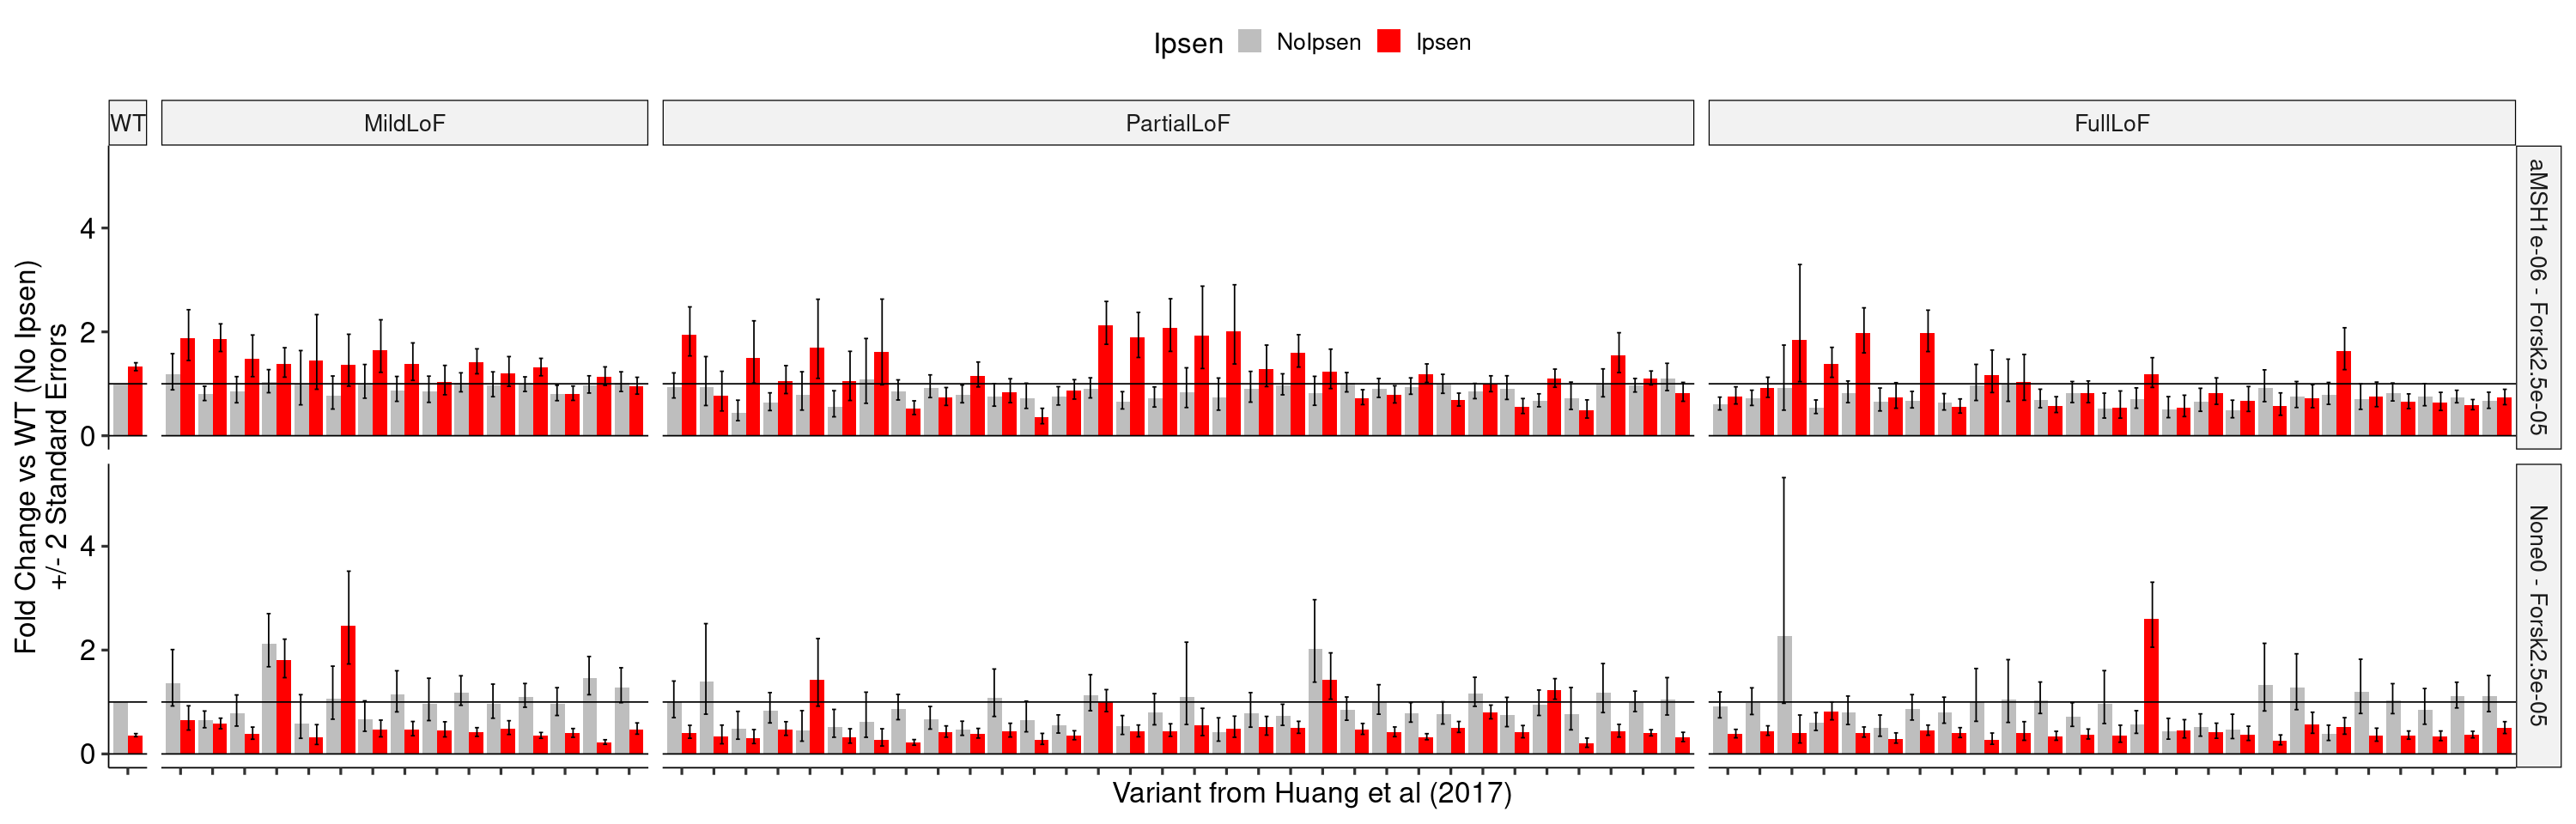

In [108]:
barplot_data_huang <- sumstats_all %>%
    mutate(mut_id = gsub("_.*", "", paste0(pos, aa))) %>% 
    inner_join(huang2017, by = c("mut_id" = "mut")) %>% 
    separate(aa, c("aa", "Ipsen"), sep = "_") %>%
    mutate(aa = if_else(aa == "X", "Stop", aa),
           #aa = relevel(as.factor(aa), ref = "WT"),
           Ipsen = relevel(as.factor(Ipsen), ref = "NoIpsen")) %>%
    bind_rows(wt_ref) %>%
    bind_rows(wt_ipsen) %>%
    mutate(Ipsen = fct_rev(Ipsen),
           class = factor(class, levels = c("WT", "MildLoF", "PartialLoF", "FullLoF")))

options(repr.plot.width = 25, repr.plot.height = 8, warn = -1)
barplot_huang <- ggplot(barplot_data_huang) +
        geom_bar(aes(x = reorder(mut_id, pos), y = 2^estimate,
                       #ymin = estimate - 2*std.error,
                       #ymax = estimate + 2*std.error,
                       fill = Ipsen), stat = "identity",
                       position = "dodge") +
        geom_errorbar(aes(x = reorder(mut_id, pos), y = 2^estimate,
                       ymin = 2^(estimate - 2*std.error),
                       ymax = 2^(estimate + 2*std.error),
                       fill = Ipsen),
                       position = position_dodge(width = 1), width = 0.25) +
        theme_pubr(base_size = 20) +
        scale_fill_manual(values = c("NoIpsen" = "gray", "Ipsen" = "red")) +
        facet_grid(rows = vars(condition), cols = vars(class), scales = "free_x", space = "free") +
        geom_hline(yintercept = 0) +
        ylab("Fold Change vs WT (No Ipsen)\n+/- 2 Standard Errors") +
        xlab("Variant from Huang et al (2017)") +
        geom_hline(yintercept = 1) +
        theme(axis.text.x = element_blank())

barplot_huang

For plotting convienence, we can slim this down to just the top 15 and bottom 15 variants, ranked by the size of the gap between Ipsen and No Ipsen in the aMSH condition. This removes enough data points that we can leave the labels there, and they are still legible:

In [102]:
barplot_data_huang_wide <- barplot_data_huang %>%
    select(condition, pos, aa, Ipsen, estimate, std.error, statistic, p.value, p.adj) %>%
    pivot_wider(names_from = Ipsen, values_from = c(estimate, std.error, statistic,
                                                    p.value, p.adj)) 

barplot_data_huang_top <- barplot_data_huang_wide %>%
    group_by(condition) %>%
    slice_max(statistic_Ipsen - statistic_NoIpsen, n = 15) %>%
    mutate(group = "Responders")

barplot_data_huang_bottom <- barplot_data_huang_wide %>%
    group_by(condition) %>%
    slice_min(abs(statistic_Ipsen - statistic_NoIpsen), n = 15) %>%
    mutate(group = "Non-Responders")

barplot_data_huang_30 <- bind_rows(barplot_data_huang_top, barplot_data_huang_bottom) %>%
    mutate(mut_id = paste0(pos, aa)) %>%
    ungroup() %>%
    select(condition, mut_id, group) %>%
    mutate(mut_id = gsub("Stop", "X", mut_id))

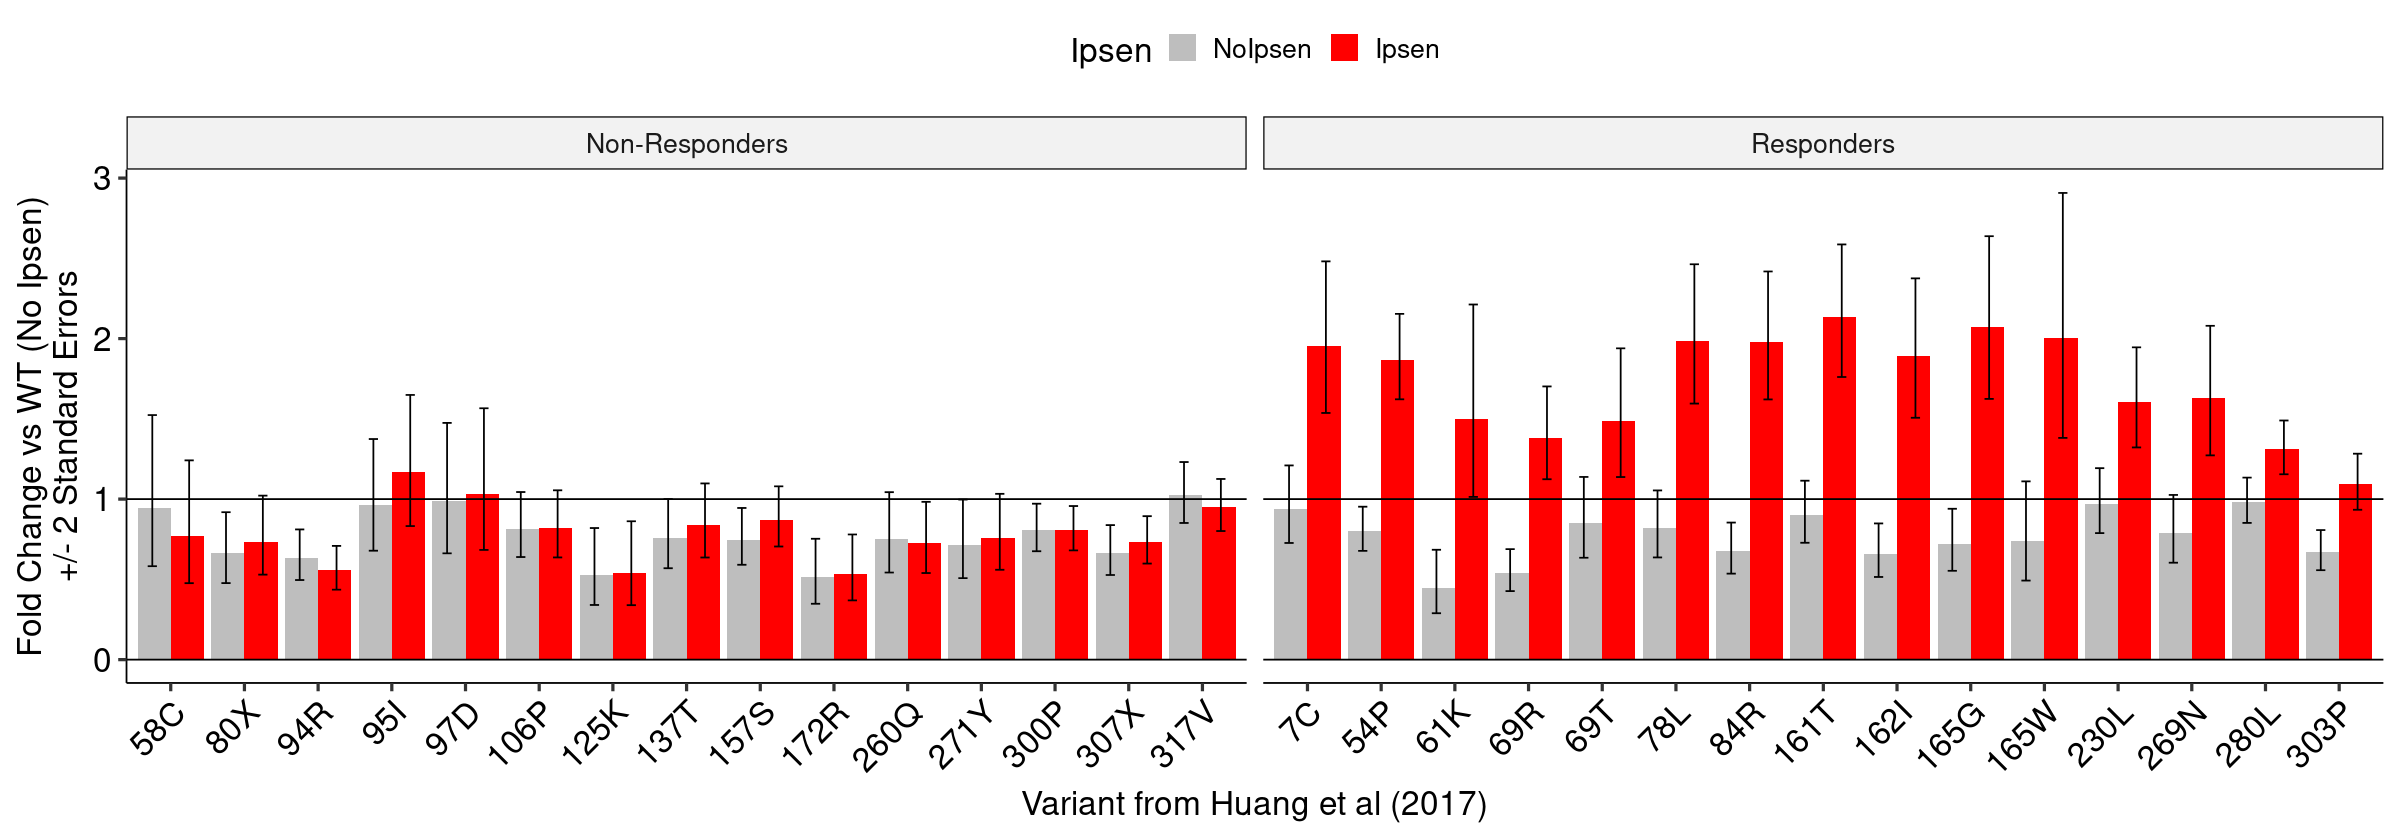

In [107]:
options(repr.plot.width = 20, repr.plot.height = 7, warn = -1)
barplot_huang <- barplot_data_huang %>%
    filter(grepl("aMSH", condition)) %>%
    inner_join(barplot_data_huang_30, by = c("condition", "mut_id")) %>%
    ggplot() +
        geom_bar(aes(x = reorder(mut_id, pos), y = 2^estimate,
                       #ymin = estimate - 2*std.error,
                       #ymax = estimate + 2*std.error,
                       fill = Ipsen), stat = "identity",
                       position = "dodge") +
        geom_errorbar(aes(x = reorder(mut_id, pos), y = 2^estimate,
                       ymin = 2^(estimate - 2*std.error),
                       ymax = 2^(estimate + 2*std.error),
                       fill = Ipsen),
                       position = position_dodge(width = 1), width = 0.25) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        scale_fill_manual(values = c("NoIpsen" = "gray", "Ipsen" = "red")) +
        facet_wrap(~ group, scales = "free_x") +
        geom_hline(yintercept = 0) +
        ylab("Fold Change vs WT (No Ipsen)\n+/- 2 Standard Errors") +
        xlab("Variant from Huang et al (2017)") +
        geom_hline(yintercept = 1) 

ggsave("../dataviz/MC4R/MC4R-Gs-Ipsen-AltMod-Huang2017.pdf", barplot_huang,
       width = 20, height = 7)
barplot_huang